In [11]:
import pandas as pd
from birdsong_dataset import AudioDataset , SoundData
from torch.utils.data import random_split, DataLoader
import numpy as np
import torch
import cv2 as cv
from matplotlib import pyplot as plt
from torch import nn, optim
import torch


In [12]:
torch.cuda.is_available()
print("test")

True

In [13]:
df = pd.read_csv("./data/birdsong_metadata.csv")
df.nunique()
device = "cuda"

In [14]:

class transpose_layers(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # print(sample.shape)
        
        transposed = sample.transpose((2, 0, 1))
        return transposed


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # print(sample.shape)
        
        
        return torch.tensor(sample[0]).to(device) , torch.tensor(sample[1]).to(device) , torch.tensor(sample[2]).to(device)


In [15]:
sounds = SoundData(df , transform = transpose_layers(), max_len= 2 , overlapping = 0.5 , noise_reduction=False, noise_reduction_level=0.6)
dataset = AudioDataset(sounds.train , transform = ToTensor())



Loading The Data...
Data Loaded !


In [ ]:
# plt.figure(figsize=(10,10))
# counter = 1
# for i in range(1):
#     for j in range(1):
#         plt.subplot(1,1,counter)
#         counter+=1
#         plt.title(train[i][1].item())
#         if j % 2 == 0 :
#             plt.imshow(train[i][0].to('cpu').numpy().transpose((1,2,0)))
#         else:
#             plt.imshow(train[i][0].to('cpu').numpy().transpose((1,2,0)))
        
             

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title(dataset[i+20][1].item())
    plt.imshow(dataset[i+20][0].to('cpu').numpy().transpose((1,2,0)))

In [16]:



class BirdSongClassifier(nn.Module):
    def __init__(self, num_classes_1 = 88 , num_classes_2 = 85):
        super(BirdSongClassifier,self).__init__()
        # backbone
        self.conv1 = nn.Conv2d( in_channels=1, out_channels= 64 , kernel_size=3)
        self.norm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((3,3))
        self.conv2 = nn.Conv2d( in_channels=64, out_channels=128 , kernel_size=3)
        self.norm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((3,3))
        self.conv3 = nn.Conv2d( in_channels=128, out_channels=64 , kernel_size=3)
        self.norm3 = nn.BatchNorm2d(64)
        # self.relu3 = nn.ReLU()
        # self.pool3 = nn.MaxPool2d((3,3))
        
        # multilabel classification for name 
        
        self.names_l1 = nn.Linear(64*11*6 ,512 )
        self.names_relu1 = nn.ReLU()
        self.names_l2 = nn.Linear(512 , num_classes_1 )
        
        # multilabel classification for species       
        
        # self.species_l1 = nn.Linear(64*11*2 ,512 )
        # self.species_relu1 = nn.ReLU()
        # self.species_l2 = nn.Linear(512 , num_classes_2 )
        # self.to(device)

        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.norm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        backbone = self.norm3(x)
        # x = self.relu3(x)
        # backbone = self.pool3(x)
        # print("Backbone Shape : ", backbone.size())
        #forward for names
        x1 = backbone.view(-1, 64*11*6)
        x1 = self.names_l1(x1.reshape(-1,64*11*6))
        x1 = self.names_relu1(x1)
        x1 = self.names_l2(x1)
        # print("Name Head Shape = " ,x1.shape)

        #forward for species

        # x2 = backbone.view(-1, 64*11*2)
        # x2 = self.species_l1(x2.reshape(-1,64*11*2))
        # x2 = self.species_relu1(x2)
        # x2 = self.species_l2(x2)
        return x1 

    def test_model(self, data_loader):
        """
        Test a model on a specified dataset.
    
        Inputs:
            net - Trained model of type BaseNetwork
            data_loader - DataLoader object of the dataset to test on (validation or test)
        """
        self.eval()
        
        true_preds_names, true_preds_species,  count = 0., 0., 0
        
        for imgs, names , species in data_loader: 
            imgs, names , species = imgs.to(device), names.to(device) , species.to(device)
            with torch.no_grad():
                preds = self(imgs)
                preds_names = preds[0].argmax(dim=-1)
                # preds_species = preds[1].argmax(dim=-1)
                true_preds_names += (preds_names == names )[0].sum().item()
                # true_preds_species += (preds_species == species )[0].sum().item()
                count += 2
        test_acc = (true_preds_names +  true_preds_species) / count
        return test_acc
model = BirdSongClassifier()
model.to('cuda')


BirdSongClassifier(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (names_l1): Linear(in_features=4224, out_features=512, bias=True)
  (names_relu1): ReLU()
  (names_l2): Linear(in_features=512, out_features=88, bias=True)
)

In [17]:

# Define the sizes of your desired splits
train_size = int(0.6 * len(dataset))  # 60% of the data for training
val_size = int(0.25 * len(dataset))   # 25% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining data for testing

# Use random_split with shuffled indices to create the splits
train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

batch_size = 1
# You can then create data loaders for each split if needed
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

model.test_model(test_loader)

0.0037481259370314842

In [ ]:

import os



# Define loss function and optimizer
criterion_names = nn.CrossEntropyLoss()
criterion_species = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
max_val_accuracy = 0 
# Training loop
print(device)
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    for i, (inputs, labels_names, labels_species) in enumerate(train_loader):
        inputs , labels_names , _ = inputs.to(device), labels_names.to(device) , labels_species
        # from torch.profiler import profile, record_function, ProfilerActivity
        # 
        # with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
        #     with record_function("model_inference"):
        #         model(inputs)
        # print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
        # 
        optimizer.zero_grad()
        # Forward pass
        outputs_names  = model(inputs.type(torch.cuda.FloatTensor).to(device))
        # print(outputs_names.shape)
        # print(labels_names.shape)
        # print(torch.argmax(outputs_names , dim=-1).item(), labels_names.item() ,"-------", torch.argmax(outputs_species , dim=-1).item(), labels_species.item())
        # time.sleep(0.1)
        
        # Calculate loss
        loss_names = criterion_names(outputs_names, labels_names.type(torch.cuda.LongTensor).to(device))
        # loss_species = criterion_species(outputs_species, labels_species.type(torch.LongTensor).to(device))
        t_loss_names = loss_names 
        # t_loss_species = loss_species
        # print(t_loss_names , t_loss_species)
        total_loss = loss_names
        # Backward pass
        total_loss.backward()
        # t_loss_species.backward(retain_graph= True)
        # Update weights
        optimizer.step()
        
        # print(total_loss)
        # optimizer_species.step()
        # print(total_loss)
        running_loss += total_loss.item()
        print(f"\r Step = {i}, Loss = {running_loss:<10.4}", end=" ")

        
        # running_loss_species += t_loss_species.item()
        
        # Print statistics every 100 batches
    if (epoch + 1) % 1 == 0:
        train_acc = model.test_model(train_loader) 
        val_acc = model.test_model(val_loader)
        if epoch > 0 and val_acc > 0.6 and val_acc > max_val_accuracy :
            torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, f"best.pt")
            max_val_accuracy = val_acc
        
        print(f'\t|| Epoch [{epoch + 1}/{num_epochs}], Training Loss : { running_loss  :.6f} , Train Acc : {train_acc:.4f}, Val Acc : {val_acc:.8f} , Best Acc : {max_val_accuracy:0.8f}')
    if (epoch + 1) % 10 == 0:
        test_acc = model.test_model(test_loader)
        print(f"TEST ACCURACY : {test_acc:0.4f}")
print('Finished Training')

cuda
 Step = 2661, Loss = 970.1      	|| Epoch [1/500], Training Loss : 970.072017 , Train Acc : 0.4414, Val Acc : 0.35166817 , Best Acc : 0.00000000
 Step = 2661, Loss = 353.4      	|| Epoch [2/500], Training Loss : 353.444489 , Train Acc : 0.4782, Val Acc : 0.37285843 , Best Acc : 0.00000000
 Step = 2661, Loss = 118.6      	|| Epoch [3/500], Training Loss : 118.562849 , Train Acc : 0.4711, Val Acc : 0.37285843 , Best Acc : 0.00000000
 Step = 2661, Loss = 73.35      	|| Epoch [4/500], Training Loss : 73.345368 , Train Acc : 0.4786, Val Acc : 0.37556357 , Best Acc : 0.00000000
 Step = 2661, Loss = 54.46      	|| Epoch [5/500], Training Loss : 54.464396 , Train Acc : 0.4820, Val Acc : 0.38367899 , Best Acc : 0.00000000
 Step = 2661, Loss = 44.34      	|| Epoch [6/500], Training Loss : 44.342321 , Train Acc : 0.4797, Val Acc : 0.37962128 , Best Acc : 0.00000000
 Step = 2661, Loss = 37.14      	|| Epoch [7/500], Training Loss : 37.144438 , Train Acc : 0.4716, Val Acc : 0.36789901 , Best A

In [ ]:
# device = torch.device("cuda")
# model_ft = BirdSongClassifier()
# optimizer_ft = optim.SGD(model.parameters(), lr=0.00001)
# 
# checkpoint = torch.load("best.pt" , map_location= device)
# model_ft.load_state_dict(checkpoint['model_state_dict'])
# optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# model_ft.to(device)

In [ ]:
# num_epochs = 1000
# for epoch in range(num_epochs):
#     model_ft.train()
#     running_loss = 0.0
#     for i, (inputs, labels_names, labels_species) in enumerate(train_loader):
# 
#         labels_names , labels_species = labels_names.to("cuda") , labels_species.to("cuda")
#         optimizer.zero_grad()
#         # Forward pass
#         outputs_names , outputs_species = model_ft(inputs.type(torch.cuda.FloatTensor))
#         # print(torch.argmax(outputs_names , dim=-1).item(), labels_names.item() ,"-------", torch.argmax(outputs_species , dim=-1).item(), labels_species.item())
#         # time.sleep(0.1)
# 
#         # Calculate loss
#         loss_names = criterion_names(outputs_names, labels_names.type(torch.cuda.LongTensor) )
#         loss_species = criterion_species(outputs_species, labels_species.type(torch.cuda.LongTensor))
#         t_loss_names = loss_names 
#         t_loss_species = loss_species
#         total_loss = loss_names + loss_species
#         # Backward pass
#         total_loss.backward()
#         # t_loss_species.backward(retain_graph= True)
#         # Update weights
#         optimizer.step()
#         # optimizer_species.step()
#         running_loss += total_loss.item()
#         # running_loss_species += t_loss_species.item()
# 
#         # Print statistics every 100 batches
#     if (epoch + 1) % 1 == 0:
#         train_acc = model_ft.test_model(train_loader) 
#         val_acc = model_ft.test_model(val_loader)
# 
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss : {running_loss :.6f} , Train Acc : {train_acc:.4f}, Val Acc : {val_acc:.8f}')


print('Finished Training')

In [ ]:
# input = torch.randn(1, 5, requires_grad=True)
# input.shape

In [ ]:
# target = torch.empty(1, dtype=torch.long).random_(5)
# target.shape

BirdSongClassifier(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (names_l1): Linear(in_features=4224, out_features=512, bias=True)
  (names_relu1): ReLU()
  (names_l2): Linear(in_features=512, out_features=88, bias=True)
)
Input Tensor Shape: torch.Size([1, 1, 128, 87])
Target Tensor Shape: torch.Size([1])


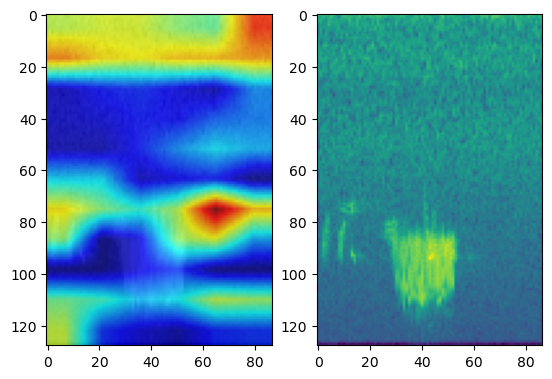

In [83]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model = model
print(model.eval())
target_layers = [model.conv3]

input_tensor = None
for input, target_name , _ in train_loader:
    print("Input Tensor Shape:", input.shape)
    print("Target Tensor Shape:", target_name.shape)
    input_tensor = input
    break
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(87)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
# print()
visualization = show_cam_on_image((dataset[1][0] * 1/255).to('cpu').numpy().transpose((1,2,0)), grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs

plt.subplot(1,2,1)
plt.imshow(visualization )
plt.subplot(1,2,2)
plt.imshow((dataset[1][0] * 1/255).to('cpu').numpy().transpose((1,2,0)))
plt.show()


tensor([[ 1.8679,  1.0405, -1.5601, -0.3848,  0.7026, -1.2386,  0.4868,  1.3869,
          0.7637,  2.7170, -0.0424, -0.4742,  2.5050, -2.5081, -0.0357, -2.6945,
          0.1057,  0.1159,  0.8469,  0.2076, -0.2735,  0.0282,  1.0490,  1.6609,
          2.3215,  5.1676, -1.2028, -0.9121, -1.0667,  0.2360, -1.5526,  0.2276,
         -1.0326, -2.4966, -2.3474,  0.2694,  0.4373, -0.3394,  0.7730,  2.3824,
          0.4639, -1.5997,  1.3439, -1.2910, -1.4850, -0.8401, -0.5230, -2.2010,
          0.5990, -2.0089, -0.2452, -2.1805,  0.3317,  0.5634,  1.4964, -0.7726,
         -1.9414,  0.5185,  0.5164, -2.3385,  0.1921, -1.3411, -0.0682, -0.9408,
         -2.4075,  0.9728, -1.0044, -1.0097,  2.1225, -1.2251,  0.9176,  2.5326,
         -1.9908, -1.8509,  1.3585,  2.1645,  0.0782, -0.3804, -0.9905,  1.4585,
         -2.1086, -0.1605, -3.0727,  0.9206, -1.0110, -0.3424, -1.9428,  1.9006]],
       grad_fn=<ToCopyBackward0>)

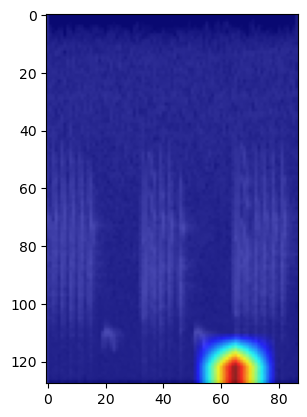